# Bachelier 

We consider the Bachelier model for a call option with European payoff $(S_T - K)^+$:

$$
d{F_t} = \sigma d{W_t},
$$

where:
- $d{W_t}$ denotes a Wiener process
- $\sigma$ is the constant volatility

This is a simplified view using a forward measure and forward price: $F_t=S_t e^{r(T-t)}$, where $r$ is the risk-free interest rate.

Furthermore, consider Gaussian basket: $$F_t = \sum_{i=0}^{m} \omega_i F^{[i]}_t.$$
It is a weighted sum of the underlying jointly Gaussian distributed assets.
Unlike lognormally distributed prices, the basket price $F_t$ is again Gaussian.
That is why the Bachelier model is again applicable.

In the following code the spot and forward price are used interchangibly.


We can discretize this SDE using, e.g., the Euler-Maryuama scheme. Then the samples for training are computed using Monte Carlo and the pathwise derivative method. 

# General Imports and Settings

In [1]:
# Make sure the following packages are installed:
# matplotlib, numpy, jaxlib, jax, jaxtyping, optax, chex, tensorflow, tensorflow-datasets

%pip install matplotlib
%pip install numpy

# install required jax packages
%pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install equinox jaxtyping optax chex

# install tensorflow datasets for data loading
%pip install tensorflow
%pip install tensorflow-datasets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
# For Google Colab
%pip install jaxtyping
%pip install equinox

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# option to disable preallocation. Otherwise Jax will commit 90% of VRAM (GPU) 
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Callable
from jaxtyping import Array, Float, Int, PyTree

import equinox as eqx
import optax
import chex

# we use tf with tfds for loading the data
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
# Note: The warnings from tf can safely be ignored.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

# check for nans etc.
jax.enable_checks = True

2023-11-07 12:44:07.748065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 12:44:07.748091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 12:44:07.748114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# check if jax recognizes the GPU
jax.devices()

[cuda(id=0)]

In [3]:
# list requirements of latest run
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

jax==0.4.20
equinox==0.11.1
optax==0.1.7
chex==0.1.83
tensorflow==2.14.0
tensorflow_datasets==4.9.3
numpy==1.24.4


In [20]:
# optional style change for print-ready figures
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "EB Garamond",
    "font.size": 20
})

In [89]:
# global settings

NUM_EPOCHS = 100
BATCH_SIZE = 512
BUFFER_SIZE = 1024
LEARNING_RATE = 0.01
N_TRAINING_SAMPLES = 8 * 1024
N_TEST_SAMPLES = 4096
SEED = 42

In [90]:
# helper functions

@eqx.filter_jit
def value_and_jacrev(f, x):
    # Function that computes both the values and the Jacobian using reverse mode autodiff
    y, vjpfun = jax.vjp(f, x)  # Compute the values and obtain a VJP function
    basis = jnp.eye(y.size, dtype=y.dtype)
    jac = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
    return y, jac, vjpfun

@eqx.filter_jit
def value_and_jacobian(f, x):
    y, jac, _ = value_and_jacrev(f, x)
    return y, jac

In [91]:
def mse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.mean((y - pred_y) ** 2)

In [92]:
def rmse(y: Float[Array, "n"], pred_y: Float[Array, "n"]) -> Float:
    return jnp.sqrt(mse(y, pred_y))

# Smoothing

In [93]:
def sigmoidal_smoothing(f1: Callable, f2: Callable, p=0.0, w=0.005):
    """
    Smoothly transition between two functions using sigmoidal smoothing.

    Args:
        f1 (callable): The first function, f1(x), where x is a real number.
        f2 (callable): The second function, f2(x), where x is a real number.
        p (float, optional): The position to transition between the two functions. Default is 0.0.
        w (float, optional): The width of the smoothing. Default is 0.005.

    Returns:
        callable: A function that smoothly transitions between f1 and f2 at point p.

    Example:
        zero_fn = lambda x: jnp.zeros_like(x)
        id_fn   = lambda x: x
        smooth_fn = sigmoidal_smoothing(zero_fn, id_fn, p=1.0, w=0.01)
        result = smooth_fn(0.5)
    """

    def sigma(x):
        """
        Sigmoid function for smoothing.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the sigmoid function.
        """
        return 1.0 / (1.0 + jnp.exp(-(x-p)/w))

    def smooth_f(x):
        """
        Smoothed function.

        Args:
            x (float): The input value.

        Returns:
            float: The result of the smoothed function.
        """
        return (1 - sigma(x)) * f1(x) + sigma(x) * f2(x)

    return smooth_f


In [94]:
smooth_relu = sigmoidal_smoothing(lambda x: jnp.zeros_like(x), lambda x: x)

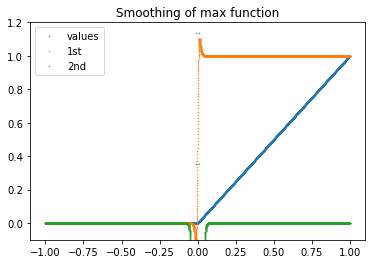

In [95]:
xs = jnp.linspace(-1e-0, 1e-0, 10000)
ys = smooth_relu(xs)
dys = jax.vmap(jax.grad(smooth_relu))(xs)
ddys = jax.vmap(jax.hessian(smooth_relu))(xs)


plt.title("Smoothing of max function")
plt.plot(xs, ys, '.', markersize=1.0, label="values")
plt.plot(xs, dys, '.', markersize=1.0, label="1st")
plt.plot(xs, ddys, '.', markersize=1.0, label="2nd")
plt.ylim([-0.1, 1.2])
plt.legend()
plt.show()

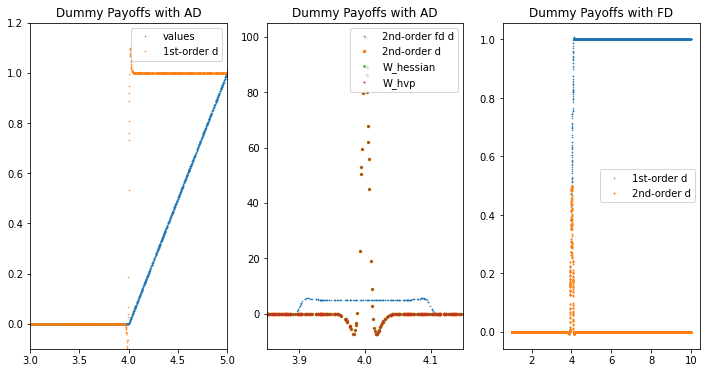

In [96]:
# Example visualizaiton of smoothed payoff and its (second-order) derivative
K = 4

def dummy_payoff(xs, K=4):
    return jnp.maximum(0, xs - K)

smoothed_dummy_payoff = lambda x, K=4: smooth_relu(x - K)
dummy_payoff = smoothed_dummy_payoff

seed = 42
n = N_TRAINING_SAMPLES
key = random.PRNGKey(seed)
key, subkey = random.split(key)
xs = random.uniform(subkey, shape=(n,), minval=1.0, maxval=10.0)
ys = dummy_payoff(xs)

# AD
dpayoff = grad(dummy_payoff)
dys = vmap(dpayoff)(xs)
ddys = vmap(grad(dpayoff))(xs)

Z_jacobian = jax.vmap(jax.jacobian(dummy_payoff))(xs)
assert(jnp.allclose(dys, Z_jacobian))
W_hessian = jax.vmap(jax.hessian(dummy_payoff))(xs)
assert(jnp.allclose(ddys, W_hessian))

Y_vjp, vjpfun = jax.vjp(dummy_payoff, xs)
basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function
W_hvp = jax.jvp(jax.vmap(jax.grad(dummy_payoff)), (xs, ), (jnp.ones_like(xs), ))[1]

# FD over AD
h = 0.1
fd_xph = vmap(dpayoff)(xs + h)
fd_xmh = vmap(dpayoff)(xs - h)
ddys_fd = (fd_xph - fd_xmh) / (2 * h)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

# First plot
axs[0].set_title("Dummy Payoffs with AD")
axs[0].plot(xs, ys, '.', markersize=1, label='values')
axs[0].plot(xs, dys, '.', markersize=1, label='1st-order d')
axs[0].set_xlim([K-1, K+1])
axs[0].set_ylim([-.1, 1.2])
axs[0].legend()

# Second plot
axs[1].set_title("Dummy Payoffs with AD")
axs[1].plot(xs, ddys_fd, '.', markersize=1, label='2nd-order fd d')
axs[1].plot(xs, ddys, '.', markersize=5, label='2nd-order d')
axs[1].plot(xs, W_hessian, '.', markersize=3, label='W_hessian')
axs[1].plot(xs, W_hvp, '.', markersize=2, label='W_hvp')
axs[1].set_xlim([K-1.5e-1, K+1.5e-1])
axs[1].legend()

# FD
h = 0.1
fd_xph = dummy_payoff(xs + h)
fd_xmh = dummy_payoff(xs - h)
fd = (fd_xph - fd_xmh) / (2 * h)
fdd = (fd_xph - 2 * ys + fd_xmh) / (2 * h)

# Third plot
axs[2].set_title("Dummy Payoffs with FD")
axs[2].plot(xs, fd, '.', markersize=1, label='1st-order d')
axs[2].plot(xs, fdd, '.', markersize=2, label='2nd-order d')
axs[2].legend()

plt.show()

# Bachelier Dataset

## Analytic solution

In [118]:
# Initial Bachelier code was adapted from Huge & Savine, 2020, Differential Machine Learing

# analytic solutions
def bachPrice(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return  vol * jnp.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def bachDelta(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.cdf(d)

def bachVega(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return jnp.sqrt(T) * norm.pdf(d)

def bachGamma(spot, strike, vol, T):
    d = (spot - strike) / vol / jnp.sqrt(T)
    return norm.pdf(d) / (vol * jnp.sqrt(T))

def analytic_grad(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = jnp.maximum(0, bkt2 - K)

    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = jnp.maximum(0, bkt2a - K)
        
        # differentials
        Z1 =  jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z2 =  jnp.where(bkt2a > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        Z_analytic = 0.5 * (Z1 + Z2)
                
    else: # standard 
        Z_analytic = jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)) * a.reshape((1,-1))
        jax.debug.print("analytic {}", jnp.where(bkt2 > K, 1.0, 0.0).reshape((-1,1)).shape)
        jax.debug.print("weights {}",  a.reshape((1,-1)).shape)
        jax.debug.print("z_analytic {}", Z_analytic.shape)

    return Z_analytic

## Training data generator

In [119]:
@dataclass(eq=True, frozen=True)
class BachelierParams:
    n_dim: int = 1
    T1: float = 1.0
    T2: float = 2.0
    K: float = 1.10
    test_set_lb = 0.5
    test_set_ub = 1.50
    volMult: float = 1.5
    bktVol: float = 0.2
    anti: bool = False

class TrainingSet(eqx.Module):
    X: Array 
    Y: Array
    Z: Array
    W: Array
    weights: Array
    inc1: Array
    Z_fd: Array
    W_fd_of_fd: Array
    W_fd_of_vjp: Array
    W_fd_of_grad: Array

    def shapes(self):
        jax.debug.print("X {X}, Y {Y}, Z {Z}, W {W}", X=X.shape, Y=Y.shape, Z=Z.shape, W=W.shape)

class TestSet(eqx.Module):
    spots: Array
    baskets: Array
    prices: Array
    deltas: Array
    vegas: Array
    gammas: Array


def payoff_fn(X, inc1, a, K, anti=False):
    S2 = X + inc1
    bkt2 = jnp.dot(S2, a)
    pay = smooth_relu(bkt2 - K)
    
    if anti: # two antithetic paths
        S2a = X - inc1
        bkt2a = jnp.dot(S2a, a)
        paya = smooth_relu(bkt2a - K)
        Y = 0.5 * (pay + paya)
    else: # standard
        Y = pay

    return Y
    
# generate a random correlation matrix
def genCorrel(key, n):
    randoms = random.uniform(key, shape=(2*n, n), minval=-1., maxval=1.)
    cov = randoms.T @ randoms
    invvols = jnp.diag(1. / jnp.sqrt(jnp.diagonal(cov)))
    return jnp.linalg.multi_dot([invvols, cov, invvols])

# training set: returns S1 (mxn), C2 (mx1) and dC2/dS1 (mxn)
@partial(jit, static_argnums=(0,1,2,3))
def trainingSet(m: int, params: BachelierParams, seed=2, bktVol=0.2) -> TrainingSet:
    n = params.n_dim
    T1 = params.T1
    T2 = params.T2
    K = params.K
    volMult = params.volMult

    key = random.PRNGKey(seed)

    # spots all currently 1, without loss of generality
    S0 = jnp.repeat(1., n)
    # random correl
    key, subkey = random.split(key)
    corr = genCorrel(subkey, n)
    jax.debug.print("corr is {}", corr)
    # random weights
    key, subkey = random.split(key)
    a = random.uniform(subkey, shape=(n,), minval=1., maxval=10.)
    a /= jnp.sum(a)
    jax.debug.print("basket asset weights are {}", a)
    # random vols
    key, subkey = random.split(key)
    vols = random.uniform(subkey, shape=(n,), minval=5., maxval=50.)
    jax.debug.print("vols is {}", vols.shape)
    # normalize vols for a given volatility of basket, 
    # helps with charts without loss of generality
    avols = (a * vols).reshape((-1,1))
    jax.debug.print("avols is {}", avols.shape)
    v = jnp.sqrt(jnp.linalg.multi_dot([avols.T, corr, avols]).reshape(1))
    jax.debug.print("v.shape is {}", v.shape)
    vols = vols * bktVol / v
    bktVol = bktVol
    jax.debug.print("bkt vol is= {v}", v=bktVol)

    # Choleski etc. for simulation
    diagv = jnp.diag(vols)
    jax.debug.print("diagv {}", diagv.shape)
    cov = jnp.linalg.multi_dot([diagv, corr, diagv])
    jax.debug.print("cov {}", cov.shape)
    chol = jnp.linalg.cholesky(cov) * jnp.sqrt(T2 - T1)
    # increase vols for simulation of X so we have more samples in the wings
    chol0 = chol * volMult * jnp.sqrt(T1 / (T2 - T1))
    # simulations
    key, subkey = random.split(key)
    normals = random.normal(subkey, shape=(2, m, n))

    jax.debug.print("normals 0 is {}", normals[0, :, :].shape)
    jax.debug.print("chol0 is {}", chol0.T.shape)
    inc0 = normals[0, :, :] @ chol0.T

    jax.debug.print("inc0.shape is {}", inc0.shape)
    
    inc1 = normals[1, :, :] @ chol.T

    S1 = S0 + inc0

      
    payoff = partial(payoff_fn, a=a, K=K, anti=params.anti)

    Z_analytic = analytic_grad(S1, inc1, a, K, anti=params.anti)
    # Compute the values and obtain a VJP function
    Y_vjp, vjpfun = jax.vjp(payoff, S1, inc1)
    Z_vjp = vjpfun(jnp.ones(Y_vjp.size))[0]
    
    # if not independent, we need to use the commented out section instead
    basis = jnp.eye(Y_vjp.size, dtype=Y_vjp.dtype)
    Z_vjp_full = vmap(vjpfun)(basis)[0]  # Compute the Jacobian using the VJP function

    # using first order finite differences
    h = 1e-4
    fd_ph = payoff(S1 + h, inc1)
    fd_mh = payoff(S1 - h, inc1)
    Z_fd = (fd_ph - fd_mh) / (2 * h)

    # using second order finite differences
    h = 1e-2
    fdd = (fd_ph - 2 * Y_vjp + fd_mh) / (h * h)
    W_fd_of_fd = fdd[..., jnp.newaxis]

    # using first order finite difference over vjp
    h = 1e-4
    fd_of_vjp_ph = vjpfun(jnp.ones(Y_vjp.size) + h)[0]
    fd_of_vjp_mh  = vjpfun(jnp.ones(Y_vjp.size) - h)[0]
    W_fd_of_vjp = (fd_of_vjp_ph - fd_of_vjp_mh) / (2 * h)

    Dpayoff = vmap(jax.grad(payoff))
    W_fd_of_grad_ph = Dpayoff(S1 + h, inc1)
    W_fd_of_grad_mh = Dpayoff(S1 - h, inc1)
    W_fd_of_grad = (W_fd_of_grad_ph - W_fd_of_grad_mh) / (2 * h)

    Y, Z_grad = jax.vmap(jax.value_and_grad(payoff, argnums=0))(S1, inc1)

    jax.debug.print("Example values: {val1}, {val2}", val1=Z_grad[2,0], val2=Z_vjp[2,0])
    jax.debug.print("MSE(W_fd_of_fd, W_fd_of_vjp): {mse}", mse=mse(W_fd_of_fd, W_fd_of_vjp))
    jax.debug.print("MSE(Z_grad, Z_analytic) = {res}", res=mse(Z_grad, Z_analytic))
    jax.debug.print("MSE(Z_vjp, Z_analytic) = {res}", res=mse(Z_vjp, Z_analytic))
    jax.debug.print("MSE(Y_vjp, Y) = {res}", res=mse(Y_vjp, Y))
    jax.debug.print("Close(Y_vjp, Y) ? {res}", res=jnp.allclose(Y_vjp, Y))
    jax.debug.print("Close(Z_vjp, Z) ? {res}", res=jnp.allclose(Z_vjp, Z_analytic, rtol=1e-4, atol=1e-0))
    jax.debug.print("Close(Z_grad, Z) ? {res}", res=jnp.allclose(Z_grad, Z_analytic, rtol=1e-4, atol=1e-0))

    W_hessian = jax.vmap(jax.hessian(payoff, argnums=0))(S1, inc1)
    
    X = S1
    return TrainingSet(X, Y_vjp.reshape(-1,1), Z_vjp, W_hessian, a, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad)


## Test data generator

In [120]:
def testSet(params: BachelierParams, training_set: TrainingSet, n_samples:int=4096, seed:int=42) -> TestSet:
    # test set: returns an array of independent, uniformly random spots 
    # with corresponding baskets, ground true prices, deltas and vegas

    n = params.n_dim
    K = params.K
    bktVol = params.bktVol
    T1 = params.T1
    T2 = params.T2
    lower = params.test_set_lb
    upper = params.test_set_ub
    weights = training_set.weights
    
    key = random.PRNGKey(seed)
    # adjust lower and upper for dimension
    adj = 1 + 0.5 * jnp.sqrt((n-1)*(upper-lower)/12)
    adj_lower = 1.0 - (1.0-lower) * adj
    adj_upper = 1.0 + (upper - 1.0) * adj
    # draw spots
    key, subkey = random.split(key)
    spots = random.uniform(subkey, shape=(n_samples, n), minval=adj_lower, maxval=adj_upper)
    # compute baskets, prices, deltas and vegas
    baskets = jnp.dot(spots, weights).reshape((-1, 1))
    prices = bachPrice(baskets, K, bktVol, T2 - T1).reshape((-1, 1))
    deltas = bachDelta(baskets, K, bktVol, T2 - T1) @ weights.reshape((1, -1))
    vegas = bachVega(baskets, K, bktVol, T2 - T1)
    gammas = bachGamma(baskets, K, bktVol, T2 - T1)
    return TestSet(spots, baskets, prices, deltas, vegas, gammas) 

## Data generation

### 1D for visualization

In [121]:
bachelier_params = BachelierParams(n_dim=1, anti=True)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, Z_fd, W_fd_of_fd, W_fd_of_vjp, W_fd_of_grad = astuple(training_set)

test_set = testSet(bachelier_params, training_set, n_samples=10 * N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)

inc0.shape is (array(8192), array(1))
chol0 is (array(1), array(1))
normals 0 is (array(8192), array(1))
cov (array(1), array(1))
diagv (array(1), array(1))
bkt vol is= 0.2
v.shape is (array(1),)
avols is (array(1), array(1))
vols is (array(1),)
basket asset weights are [1.]
corr is [[1.]]
Example values: 1.0, 1.0
MSE(W_fd_of_fd, W_fd_of_vjp): 0.30469131302001895
Close(Z_vjp, Z) ? True
Close(Z_grad, Z) ? True
MSE(Z_grad, Z_analytic) = 0.0005660154384085881
MSE(Z_vjp, Z_analytic) = 0.0005660154384085881
MSE(Y_vjp, Y) = 0.0
Close(Y_vjp, Y) ? True


#### Plot generated Data

In [122]:
def plot_payoff_data(axs, x_train, y_train, x_test, y_test):
    axs.set_title("Payoff Data")
    axs.plot(x_train, y_train, '.', label='Payoff Training', markersize=1)
    axs.plot(x_test, y_test, '.', label='Payoff Test', markersize=1)
    axs.legend()

def plot_delta_data(axs, x_train, x_test, dydx_train, dydx_test):
    axs.set_title("Delta Data")
    axs.plot(x_train, dydx_train, '.', label='Delta Training', markersize=1)
    axs.plot(x_test, dydx_test, '.', label='Delta Test', markersize=1)
    axs.legend()

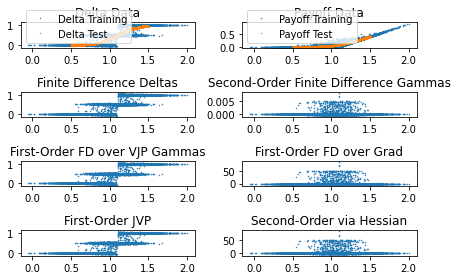

In [123]:
fig, axs = plt.subplots(4, 2)

Xs = X

plot_payoff_data(axs[0, 1], Xs, Y[:,0], baskets[:, 0], prices[:,0])
plot_delta_data(axs[0, 0], Xs, baskets[:, 0], Z[:,0], deltas[:,0])

axs[1, 0].set_title("Finite Difference Deltas")
axs[1, 0].plot(Xs, Z_fd, '.', label='FD', markersize=1)
axs[1, 1].set_title("Second-Order Finite Difference Gammas")
axs[1, 1].plot(Xs, W_fd_of_fd, '.', label='FD', markersize=1)

axs[2, 0].set_title("First-Order FD over VJP Gammas")
axs[2, 0].plot(Xs, W_fd_of_vjp, ".", label='FD', markersize=1)
axs[2, 1].set_title("First-Order FD over Grad")
axs[2, 1].plot(Xs, W_fd_of_grad, ".", label='FD', markersize=1)

axs[3, 0].set_title("First-Order JVP")
axs[3,0].plot(Xs, Z, ".", markersize=1)
axs[3, 1].set_title("Second-Order via Hessian")
axs[3,1].plot(Xs, W[:, 0, 0], ".", markersize=1)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


### 7D for training

In [124]:
use_anti = True
bachelier_params = BachelierParams(n_dim=7, anti=use_anti)
training_set = trainingSet(N_TRAINING_SAMPLES, bachelier_params, seed=42)
X, Y, Z, W, weights, inc1, fd, fdd, jac_fd, fdd_over_grad = astuple(training_set)
test_set = testSet(bachelier_params, training_set, n_samples=N_TEST_SAMPLES)
spots, baskets, prices, deltas, vegas, gammas = astuple(test_set)
payoff = partial(payoff_fn, a=weights, K=bachelier_params.K, anti=use_anti)
D_payoff = vmap(grad(payoff))

bkt vol is= 0.2
inc0.shape is (array(8192), array(7))
chol0 is (array(7), array(7))
normals 0 is (array(8192), array(7))
cov (array(7), array(7))
diagv (array(7), array(7))
v.shape is (array(1),)
avols is (array(7), array(1))
vols is (array(7),)
basket asset weights are [0.03523608 0.1942886  0.20768846 0.20812615 0.0497394  0.07701987
 0.22790145]
corr is [[ 1.         -0.40546809 -0.47076783  0.11005226  0.14389416  0.51420213
   0.42370432]
 [-0.40546809  1.          0.0184815  -0.10023294 -0.09547748 -0.04642767
   0.14553872]
 [-0.47076783  0.0184815   1.         -0.26878084  0.00815408 -0.34896792
  -0.41113086]
 [ 0.11005226 -0.10023294 -0.26878084  1.          0.03660357  0.48016104
  -0.35015074]
 [ 0.14389416 -0.09547748  0.00815408  0.03660357  1.         -0.06546545
   0.12895142]
 [ 0.51420213 -0.04642767 -0.34896792  0.48016104 -0.06546545  1.
  -0.07214193]
 [ 0.42370432  0.14553872 -0.41113086 -0.35015074  0.12895142 -0.07214193
   1.        ]]
MSE(Y_vjp, Y) = 0.0
Close

#### Plot generated Data

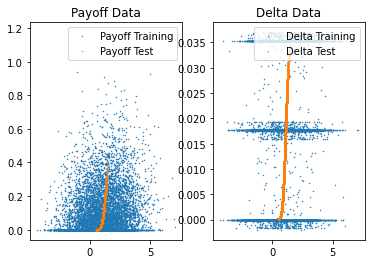

In [125]:
vis_dim = 0
fig, axs = plt.subplots(1, 2)

plot_payoff_data(axs[0], X[:,vis_dim], Y[:,vis_dim], baskets[:, vis_dim], prices[:,vis_dim])
plot_delta_data(axs[1], X[:,vis_dim], baskets[:, vis_dim], Z[:,vis_dim], deltas[:,vis_dim])

plt.show()

# Standard ML

In [126]:
@jit
def normalize(data: Array):
    mean = jnp.mean(data)
    std = jnp.std(data)
    return (data - mean) / std, mean, std

# normalize data
x_train, x_train_mean, x_train_std = normalize(X)
y_train, y_train_mean, y_train_std = normalize(Y)
dydx_train, dydx_train_mean, dydx_train_std = normalize(Z)

In [127]:
x_train = X
y_train = Y
dydx_train = Z

In [128]:
# Hyperparameters
# batch_size = 128
# learning_rate = 0.01
num_epochs = NUM_EPOCHS
seed = 42

key = jax.random.PRNGKey(seed)

In [129]:
def x_normalizer(x):
    return (x - x_train_mean) / x_train_std

def y_denormalizer(x):
    return x * y_train_std + y_train_mean

class MLP_Normalized(eqx.Module):
    layers: list

    def __init__(self, key, in_size, out_size):
        key, subkey = jax.random.split(key)
        self.layers = [x_normalizer, 
                       eqx.nn.MLP(key=subkey, in_size=in_size, out_size=out_size, width_size=20, depth=3, activation=jax.nn.relu), 
                       y_denormalizer]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [130]:
def trunc_init(weight: Array, key: jax.random.PRNGKey) -> Array:
    out, in_ = weight.shape
    stddev = jnp.sqrt(1 / in_)
    return jax.nn.initializers.glorot_normal()(key, (out, in_))

def init_linear_weight(model, init_fn, key):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear)
    get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey)
                 for weight, subkey in zip(weights, jax.random.split(key, len(weights)))]
    new_model = eqx.tree_at(get_weights, model, new_weights)
    return new_model


In [131]:
@eqx.filter_jit
def loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"]) -> Float:
    pred_y = vmap(model)(x)
    pred_y = pred_y[:, jnp.newaxis]
    result = mse(y, pred_y)
    return result

In [132]:
def evaluate(model, testloader):
    """
    This function evaluates the model on the test dataset,
    computing both the average loss.
    """
    avg_loss = 0
    for (x, y, _) in testloader:
        avg_loss += loss_fn(model, x, y)
    return avg_loss / len(testloader)

## Train

In [113]:
def train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, _) in generator_train_ds:

            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y)

        test_loss = jnp.sqrt(evaluate(model, generator_test_ds))
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

In [114]:
def gen_data_standard_ml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [133]:
def bachelier_train_standard_ml(key: Array):
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size="scalar")
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    # use linear on-cycle decay scheduler
    num_epochs = 100
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    # print(total_steps)
    # lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
    #                                                                  pct_start=0.2, pct_final=0.6,
    #                                                                  div_factor=1000., final_div_factor=1.0e4)
    
    
    lr_schedule = optax.exponential_decay(init_value=0.001, transition_steps=total_steps, transition_begin=int(total_steps*0.2), decay_rate=0.9)
    
    # lr_schedule = optax.cosine_onecycle_schedule(transition_steps=total_steps, peak_value=0.01)
    # lr_schedule = optax.constant_schedule(0.0001)
    # lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    # optim = optax.adam(learning_rate=0.001)
    # optim = optax.adam(learning_rate=lr_schedule)
    optim = optax.adam(learning_rate=lr_schedule)
    model = train(model, generator_train_ds, generator_test_ds, optim, n_epochs=num_epochs)
    return model

In [134]:
generator_train_ds, generator_test_ds, x_test = gen_data_standard_ml()
key = jax.random.PRNGKey(42)
model = bachelier_train_standard_ml(key)

Finished epoch   0  | Train Loss: 0.01123  | Test Loss: 0.05544
Finished epoch   1  | Train Loss: 0.00712  | Test Loss: 0.04239
Finished epoch   2  | Train Loss: 0.00492  | Test Loss: 0.03311
Finished epoch   3  | Train Loss: 0.00318  | Test Loss: 0.02841
Finished epoch   4  | Train Loss: 0.00247  | Test Loss: 0.02374
Finished epoch   5  | Train Loss: 0.00176  | Test Loss: 0.01854
Finished epoch   6  | Train Loss: 0.00165  | Test Loss: 0.01587
Finished epoch   7  | Train Loss: 0.00177  | Test Loss: 0.01476
Finished epoch   8  | Train Loss: 0.00167  | Test Loss: 0.01395
Finished epoch   9  | Train Loss: 0.00138  | Test Loss: 0.01326
Finished epoch  10  | Train Loss: 0.00171  | Test Loss: 0.01287
Finished epoch  11  | Train Loss: 0.00161  | Test Loss: 0.01276
Finished epoch  12  | Train Loss: 0.00173  | Test Loss: 0.01235
Finished epoch  13  | Train Loss: 0.00154  | Test Loss: 0.01208
Finished epoch  14  | Train Loss: 0.00153  | Test Loss: 0.01188
Finished epoch  15  | Train Loss: 0.0014

In [135]:
class Predictions(eqx.Module):
    y: Array
    dydx: Array
    ddyddx: Array

def predict(model, xs):
    pred_y, pred_dydx = vmap(eqx.filter_value_and_grad(model))(xs)
    pred_ddyddx = vmap(jax.hessian(model))(xs)

    return Predictions(pred_y, pred_dydx, pred_ddyddx)
    

In [136]:
pred = predict(model, x_test)

In [137]:
def eval(pred: Predictions, test_set: TestSet):
    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]
    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    rmse_y = rmse(pred_y, y_test)
    rmse_dydx = rmse(pred_dydx, dydx_test)
    rmse_ddyddx = rmse(pred_gammas, gammas)
    
    return rmse_y, rmse_dydx, rmse_ddyddx

## Plot results

### For notebook

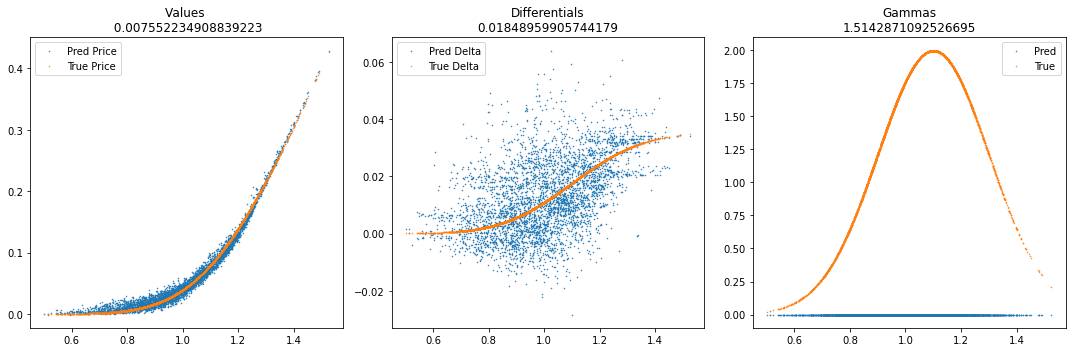

In [138]:
import datetime

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str):

    def print_rmse(pred, true):
        plt.title(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first subplot
    axes[0].plot(baskets, pred_y, '.', markersize=1)
    axes[0].plot(baskets, y_test, '.', markersize=1)
    axes[0].legend(['Pred Price', 'True Price'], loc='upper left')
    axes[0].set_title(f"Values \n {rmse(pred_y, y_test)}")

    # Plot the second subplot
    dydx_idx = 0
    axes[1].plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    axes[1].plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    axes[1].legend(['Pred Delta', 'True Delta'], loc='upper left')
    axes[1].set_title(f"Differentials\n{rmse(pred_dydx, dydx_test)}")

    # Calculate and plot gammas in the third subplot
    pred_gammas = jnp.sum(pred_ddyddx, axis=(1, 2))
    axes[2].plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    axes[2].plot(baskets, gammas, '.', markersize=1, label='True')
    axes[2].legend()
    axes[2].set_title(f"Gammas\n{rmse(pred_gammas, gammas)}")

    # Adjust the layout and save the figure to a PDF file
    plt.tight_layout()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'results/all_at_once/eval_ml_{now}.pdf', bbox_inches='tight')

plot_eval(model, pred, test_set, "ml")


### For latex

In [458]:
import datetime

BASE_PATH  = "results/single/"
VALUE_PATH = "values/"
DELTA_PATH = "deltas/"
GAMMA_PATH = "gammas/"

def plot_eval(model, pred: Predictions, test_set: TestSet, method: str, format: str = "pdf"):

    def print_rmse(pred, true):
        # plt.title(f"RMSE: {rmse(true, pred)}")
        print(f"RMSE: {rmse(true, pred)}")

    x_test, baskets, y_test, dydx_test, vegas, gammas = astuple(test_set)
    pred_y, pred_dydx, pred_ddyddx = astuple(pred)
    pred_y = pred_y[:, jnp.newaxis]

    
    fig = plt.figure()
    print_rmse(pred_y, y_test)
    # plt.suptitle("Evaluation")
    plt.plot(baskets, pred_y, '.', markersize=1)
    plt.plot(baskets, y_test, '.', markersize=1)
    # plt.ylabel(r'$V$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Price', 'True Price'], loc='upper left')
    plt.show()
    
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{VALUE_PATH}eval_{method}_{now}.{format}', bbox_inches='tight')

    
    fig = plt.figure()
    print_rmse(pred_dydx, dydx_test)
    # plt.suptitle("Differentials")
    dydx_idx = 0
    plt.plot(baskets, pred_dydx[:, dydx_idx], '.', markersize=1)
    plt.plot(baskets, dydx_test[:, dydx_idx], '.', markersize=1)
    # plt.ylabel(r'$\frac{\partial V}{\partial S_0}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend(['Pred Delta', 'True Delta'], loc='upper left')
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{DELTA_PATH}eval_delta_{method}_{now}.{format}', bbox_inches='tight')


    pred_gammas = jnp.sum(pred.ddyddx, axis=(1, 2))

    fig = plt.figure()
    print_rmse(pred_gammas, gammas)
    # plt.suptitle("Gammas")
    plt.plot(baskets, pred_gammas, '.', markersize=1, label='Pred')
    plt.plot(baskets, gammas, '.', markersize=1, label='True')
    # plt.ylabel(r'$\frac{\partial^2 V}{\partial S_0^2}$', rotation=0)
    # plt.xlabel(r'$S_0$')
    # plt.legend()
    plt.show()
    now = datetime.datetime.now()
    fig.savefig(f'{BASE_PATH}{GAMMA_PATH}eval_gamma_{method}_{now}.{format}', bbox_inches='tight')


RMSE: 0.0034459942302796616


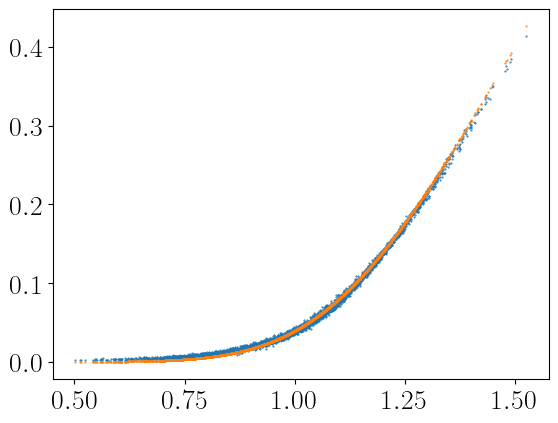

RMSE: 0.005496625771726484


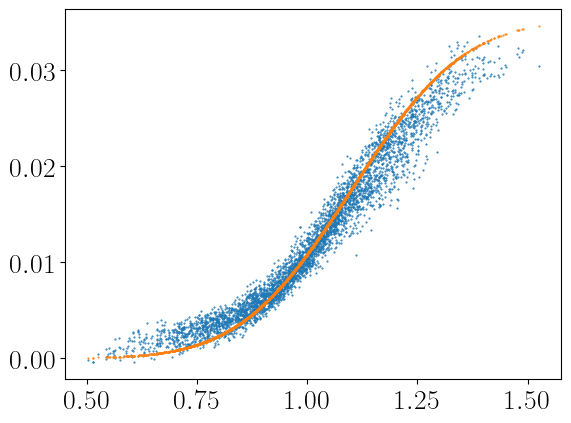

RMSE: 0.9754670337612588


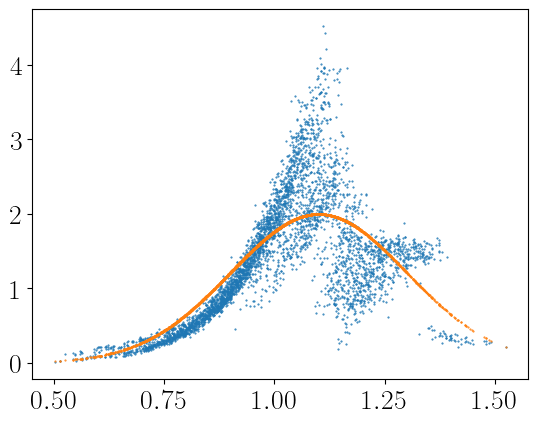

In [459]:
plot_eval(model, pred, test_set, "standard_ml")

# Differential ML

## Data generation

In [139]:
@eqx.filter_jit
def diff_loss_fn(model: eqx.nn.MLP, x: Float[Array, "batch"], y: Float[Array, "batch"], dydx: Float[Array, "batch"]) -> Float:
    lam = 1
    n_dims = x.shape[1]
    lambda_scale = lam * n_dims
    alpha = 1.0/(1.0 + lambda_scale)
    beta = lambda_scale/(1.0 + lambda_scale)

    # alpha = 0.5
    # beta = 1.0 - alpha
    y_pred, dydx_pred = vmap(eqx.filter_value_and_grad(model))(x)

    y_pred = y_pred[..., jnp.newaxis]
    dydx_pred = dydx_pred
    assert(y_pred.shape == y.shape)
    assert(dydx_pred.shape == dydx.shape)
    value_loss = alpha * jnp.mean((y_pred - y)**2)
    grad_loss = beta * jnp.mean((dydx_pred - dydx)**2)
    loss = value_loss + grad_loss

    # jax.debug.print('[Internal] Value Loss {value_loss} | Grad Loss: {grad_loss}', value_loss=value_loss, grad_loss=grad_loss)
    return loss

In [140]:
def optimal_step(x: Float):
    h = jnp.sqrt(jnp.finfo(jnp.float32).eps)
    return h * jnp.fabs(x)

## Train

In [141]:
def diff_train(model: eqx.nn.MLP,
          generator_train_ds,
          generator_test_ds,
          optim: optax.GradientTransformation,
          n_epochs: Int = NUM_EPOCHS
          ) -> PyTree:
    
    @eqx.filter_jit
    def train_step(model: eqx.nn.MLP,
                   opt_state: PyTree,
                   x: Float[Array, "batch"],
                   y: Float[Array, "batch"],
                   dydx: Float[Array, "batch"]
                   ):
        loss_value, grads = eqx.filter_value_and_grad(diff_loss_fn)(model, x, y, dydx)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for epoch in range(n_epochs):
        for (batch_x, batch_y, batch_dydx) in generator_train_ds:
            model, opt_state, train_loss = train_step(model, opt_state, batch_x, batch_y, batch_dydx)

        test_loss = rmse(vmap(model)(x_test), y_test)
        print('Finished epoch {:3d}'.format(epoch), 
                ' | Train Loss: {:.5f}'.format(train_loss),
                ' | Test Loss: {:.5f}'.format(test_loss))

    return model

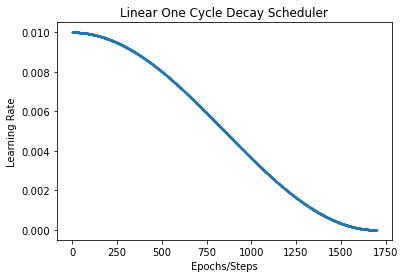

In [142]:
# linear_onecycle_decay_scheduler = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                                  pct_start=0.2, pct_final=0.6,
#                                                                  div_factor=100., final_div_factor=1.0e6)

total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
# lr_schedule = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=0.1,
#                                                 pct_start=0.2, pct_final=0.6,
#                                                 div_factor=100., final_div_factor=1.0e6)

lrs = vmap(lr_schedule)(jnp.arange(total_steps))
plt.scatter(range(total_steps), lrs, s=1)
plt.title("Linear One Cycle Decay Scheduler")
plt.ylabel("Learning Rate")
plt.xlabel("Epochs/Steps")
plt.show()

In [143]:
def gen_data_dml():
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, dydx_train))
    
    x_test = spots
    y_test = prices
    dydx_test = deltas
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test, dydx_test))
    
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    generator_train_ds = tfds.as_numpy(train_dataset)
    generator_test_ds = tfds.as_numpy(test_dataset)
    return generator_train_ds, generator_test_ds, x_test

In [146]:
def bachelier_train_dml(key: Array):
    total_steps = num_epochs * (len(x_train) // BATCH_SIZE) + num_epochs
    lr_schedule = optax.cosine_decay_schedule(init_value=0.01, decay_steps=total_steps)
    
    seed = SEED
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    model = MLP_Normalized(key, in_size=x_train.shape[1], out_size="scalar")
    
    key, subkey = jax.random.split(key)
    model = init_linear_weight(model, trunc_init, key)
    
    optim = optax.adam(learning_rate=lr_schedule)
    model = diff_train(model, generator_train_ds, generator_test_ds, optim, n_epochs=100)
    return model

In [147]:
generator_train_ds, generator_test_ds, x_test = gen_data_dml()
y_test = prices
key = jax.random.PRNGKey(42)
model = bachelier_train_dml(key)

Finished epoch   0  | Train Loss: 0.00178  | Test Loss: 0.09121
Finished epoch   1  | Train Loss: 0.00138  | Test Loss: 0.09205
Finished epoch   2  | Train Loss: 0.00123  | Test Loss: 0.09150
Finished epoch   3  | Train Loss: 0.00119  | Test Loss: 0.09308
Finished epoch   4  | Train Loss: 0.00108  | Test Loss: 0.09371
Finished epoch   5  | Train Loss: 0.00104  | Test Loss: 0.09294
Finished epoch   6  | Train Loss: 0.00107  | Test Loss: 0.09199
Finished epoch   7  | Train Loss: 0.00103  | Test Loss: 0.09164
Finished epoch   8  | Train Loss: 0.00110  | Test Loss: 0.09289
Finished epoch   9  | Train Loss: 0.00106  | Test Loss: 0.09171
Finished epoch  10  | Train Loss: 0.00106  | Test Loss: 0.09106
Finished epoch  11  | Train Loss: 0.00103  | Test Loss: 0.09276
Finished epoch  12  | Train Loss: 0.00103  | Test Loss: 0.09194
Finished epoch  13  | Train Loss: 0.00105  | Test Loss: 0.09195
Finished epoch  14  | Train Loss: 0.00101  | Test Loss: 0.09291
Finished epoch  15  | Train Loss: 0.0010

## Plot results

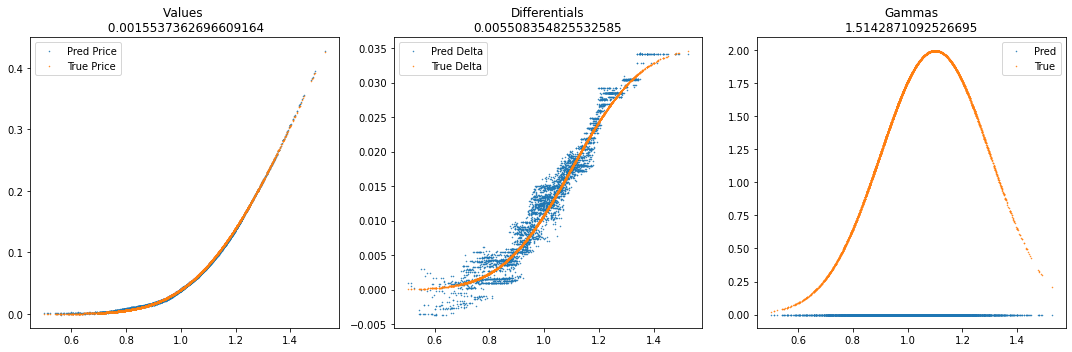

In [148]:
pred = predict(model, x_test)
plot_eval(model, pred, test_set, "dml")